In [8]:
import sys
import os
import struct
import time
import numpy as np
import gc
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
# from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import learn_params_ridge_regression, get_predictions, get_value, set_value, Torch_fwRF_voxel_block, get_r2, add_nonlinearity, get_features_in_prf, get_fmaps_sizes
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

import gfb_utils as g
import nsd_utils as n


In [9]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 3090

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [10]:
# Creating fake images (slow)

from src.load_nsd import image_uncolorize_fn
from src.file_utility import load_mask_from_nii, view_data
from src.load_nsd import image_uncolorize_fn, data_split, load_betas
from src.roi import roi_map, iterate_roi

n_images = 100
image_data = (np.random.normal(0,1,[n_images, 3, 227, 227])*30+255/2).astype(np.uint8)
image_data = np.maximum(np.minimum(image_data, 255),0)

print ('image data size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

random_images = image_uncolorize_fn(image_data)

image data size: (100, 3, 227, 227) , dtype: uint8 , value range: 2 248


In [11]:
# Parameters
from src.rf_grid import logspace
n_ori = 8
n_sf = 3

# n_ori = 18
# n_sf = 6
# n_ori = 36
# n_sf = 12
# cyc_per_stim = logspace(12)(3., 72.) # 6-92
cyc_per_stim = logspace(n_sf)(3., 72.)
# First define the feature bank itself
freqs_cpp = cyc_per_stim/227
# freqs_cpp = np.round(np.logspace(np.log10(0.02), np.log10(0.25), 3),2)
orient_step = 180/n_ori
orients_deg = np.arange(0,181-orient_step, orient_step)
spat_freq_bw = 1
spat_aspect_ratio = 1
n_sd_out = 4

process_at_size = [227,227]

# This is the code i wrote to do gabor filtering, without any downsampling of images
# i.e. filter at their original resolutions
bank = g.filter_bank(orients_deg, freqs_cpp, spat_freq_bw, spat_aspect_ratio, n_sd_out, image_size = process_at_size)


In [18]:
class gabor_feature_extractor_spat(torch.nn.Module):
    """ 
    Gabor feature extractor module that can be run on GPU, implemented w PyTorch. 
    Uses spatial convolution to filter each image w various gabor filters.
    """
    def __init__(self, filter_bank, device):
        
        super(gabor_feature_extractor_spat, self).__init__()
        
        self.bank = filter_bank
        self.filters_spat, self.orient_labs, self.freq_labs = filter_bank.get_filters_spat()
        self.filters_spat = [torch.tensor(self.filters_spat[sf]).type(torch.cfloat).to(device) for sf in range(len(self.filters_spat))]
 
    def forward(self, image_batch_tensor):
        
        # input is [n_images x 1 x n_pixels x n_pixels]
        n_images = image_batch_tensor.shape[0]
        n_in_channels = image_batch_tensor.shape[1]
        orig_size = image_batch_tensor.shape[2]
        n_ori = self.filters_spat[0].shape[0]
#         print(image_batch_tensor.shape)
        device = self.filters_spat[0].device
        
        assert(image_batch_tensor.shape[3]==image_batch_tensor.shape[2])

        complex_feature_maps = []
        
        for ff, filter_spat in enumerate(self.filters_spat):
                                          
#             sys.stdout.write('\r filtering %d of %d sfs'%(ff,len(self.filters_spat)))
            filter_size = filter_spat.shape[1]
#             print(filter_spat.shape)
            pad_by = int(np.floor(filter_size/2))

#             c = torch.nn.Conv2d(n_in_channels, n_ori, filter_size, stride=(1,1), padding=pad_by, padding_mode='replicate').to(device)
#             c = torch.nn.Conv2d(n_in_channels, n_ori, filter_size, stride=(1,1), padding=pad_by, padding_mode='zeros').to(device)
            c = torch.nn.Conv2d(n_in_channels, n_ori, filter_size, stride=(1,1), padding=pad_by, padding_mode='circular').to(device)
#             c = torch.nn.Conv2d(n_in_channels, n_ori, filter_size, stride=(1,1), padding=pad_by, padding_mode='reflect').to(device)
        
            c.weight.data = torch.real(torch.unsqueeze(filter_spat,dim=1))
            c.bias.data.fill_(0)
            realpart = c(image_batch_tensor);
#             print(realpart.shape)
            c.weight.data = torch.imag(torch.unsqueeze(filter_spat,dim=1))
            imagpart = c(image_batch_tensor)
            
            complex_feature_maps_this_sf = realpart + 1j*imagpart
#             complex_feature_maps_this_sf = realpart
           
            complex_feature_maps.append(complex_feature_maps_this_sf)
        
#         print('\n')
        complex_feature_maps = torch.cat(complex_feature_maps, axis=1)
        complex_feature_maps = torch.movedim(complex_feature_maps,[1],[3])
      
        # output is [n_images x npixels x npixels x nfeatures]
        mag = torch.abs(complex_feature_maps)
        phase = torch.angle(complex_feature_maps)
        
        
        return mag, phase

In [19]:
## Testing spatial version

gc.collect()
torch.cuda.empty_cache()

n_images= 100
sample_batch_size=2

t_start = time.time()
t = time.time()
gfe = gabor_feature_extractor_spat(bank, device=device)
# gfe = g.gabor_feature_extractor_spat(bank, device=device)
elapsed = time.time() - t
print('took %.2f s to make filters'%elapsed)

maps_spat = g.get_feature_maps_batches(gfe, random_images[0:n_images], sample_batch_size, device)

print(np.shape(maps_spat))

elapsed_total = time.time() - t_start
print('total time is %.2f s'%elapsed_total)

took 0.16 s to make filters
(100, 227, 227, 24)
total time is 8.21 s


In [52]:
## Testing frequency version

gc.collect()
torch.cuda.empty_cache()
    
    
n_images= 100
sample_batch_size=2
filter_batch_size=2

t_start = time.time()
t = time.time()
gfe = g.gabor_feature_extractor_freq(bank, filter_batch_size, device=device)
elapsed = time.time() - t
print('took %.2f s to make filters'%elapsed)

maps_freq = g.get_feature_maps_batches(gfe, random_images[0:n_images], sample_batch_size, device)

print(np.shape(maps_freq))

elapsed_total = time.time() - t_start
print('total time is %.2f s'%elapsed_total)

size of filter stack will be:
(635, 635, 24)
took 0.90 s to make filters
(100, 227, 227, 24)
total time is 2.08 s


In [12]:
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

def make_2D_sinewave(freq, theta, phase, n_pix):
    '''
    freq is cycles/image
    theta is in radians
    phase is in radians (0 pi)
    center is (x,y) in pixel coordinates
    n_pix is size of the kernel in pixels
    '''
    vec = np.array([np.cos(theta), np.sin(theta)])*2*np.pi*freq / n_pix
    
    [Xm, Ym] = np.meshgrid(np.linspace(-.5*n_pix, .5*n_pix, n_pix), np.linspace(-.5*n_pix, .5*n_pix, n_pix))
    
    proj = np.array([Xm.ravel(), Ym.ravel()]).T.dot(vec)
    
    Dt = np.sin(proj+phase)              # compute proportion of Xm for given orientation
    Dt = Dt.reshape(Xm.shape)
    
    return Dt




def make_gaussian(center, sig, n_pix):
    """
    Make a picture of a circular gaussian blob.
    center is the center of the blob in pixels. center of image is (0,0)
    sig is one std. of the gaussian (pixels)
    n_pix is the size of the picture of the gaussian blob. i.e., output will be an 2D array that is n_pix-by-n_pix
    """
    
    [Xm, Ym] = np.meshgrid(np.linspace(-.5*n_pix, .5*n_pix, n_pix), np.linspace(-.5*n_pix, .5*n_pix, n_pix))
    
    x0 = center[0]
    y0 = center[1]
    
    Z = (1. / (2*np.pi*sig**2))
    
    return Z *np.exp(-((Xm-x0)**2 + (Ym-y0)**2) / (2*sig**2))




def make_gabor(freq, theta, phase, center, sig, n_pix):
    return make_2D_sinewave(freq, theta, phase, n_pix) * make_gaussian(center, sig,n_pix)




def make_complex_gabor(freq, theta, center, sig, n_pix):
    '''
    make_complex_gabor(freq, theta, center, sig, n_pix)
    freq is spatial frequency in cycles/image
    theta is orientation in radians
    center is (x,y) in pixel coordinates. center of image is (0,0)
    sig is one std of the gaussian envelope (pixels)
    n_pix is size of the kernel in pixels
    
    '''
    phase = 0
    on_gabor = make_gabor(freq, theta, phase, center, sig, n_pix)
    phase = np.pi/2.
    off_gabor = make_gabor(freq, theta, phase, center, sig, n_pix)
    
    return off_gabor + 1j*on_gabor




def make_feature_table(num_orientations, cycles_per_stim,
                     freq_spacing='log', pix_per_cycle=2, cycles_per_radius=1, 
                     radii_per_filter=4, complex_cell=True):
    '''
    Generates a table of parameters used to apply a gabor transform.
    This approach assumes that the gabors will be of fixed size (in pixels), but the image
    the gabors are applied to are downsampled, effectively determining the spatial frequency extracted 
    from the image.
    
    Returns everything needed to construct a stack of gabor filters. 
    
    feature_table, pix_per_filter, cyc_per_filter, envelope_radius_pix =
                                      make_feature_table((num_orientations, 
                                                          cycles_per_stim,
                                                          freq_spacing='log', 
                                                          pix_per_cycle=2, 
                                                          cycles_per_radius=1, 
                                                          radii_per_filter=4, 
                                                          complex_cell=True)
                     
    num_orientations  ~ number of linearly spaced orientations in [0,pi]
    cycles_per_stim   ~ either a tuple specifying range and number of spatial frequencies in cyc/stim 
                        (lowest, highest, num), or an explicit list of spatial frequencies (as np array or list)    
    freq_spacing      ~ log or linear. spacing of spatial frequencies. used only if cycles_per_stim is given as 
                        range. 
    pix_per_cycle     ~ how many pixels will be used to depict one cycle. default = 2, i.e., the Nyquist limit.
                        If too low, will result in jaggy edges or aliasing, but if too high, usually will require 
                        stimuli with larger than native resolution.
    cycles_per_radius ~ determines radius of gaussian envelop. we specify how many cycles the sinewave completes
                        per radius (1std.) of the gaussian envelope. default = 1 = one cycle of the sinewave per 
                        std. of the gaussian envelope.
    radii_per_filter  ~ determines the size of the filter. we specify how many radii (1std. each) of the gaussian
                        envelope fits inside of the filter. default = 4.
    complex_cell      ~ default = True, meaning that ea. feature map represents a given spatial frequency 
                        that is phase invariant (the absolute value is taken between a pair of feature maps 
                        constructed using filters with 0 and pi/2 phase). if False, we distinguish between 
                        filters with 0 and pi/2 phase, resulting in 2 feature maps for each spatial frequency.
    
    returns
    feature_table        ~ a pandas table with details of each feature to be extracted from images.
    pix_per_filter       ~ number of pixels per filter.  a constant.
    cyc_per_filter       ~ number of cycles per filter.  a constant.
    envelope_radius_pix  ~ number of pixels needed for one std. of the gaussian envelope. a constant.
            
    
    Note: depending on the size of your stimuli and the given parameters, you will be limited to a certain range 
    of spatial frequencies. If the lowest frequency is too low, the filter will be larger than the downsampled 
    image, which is kind of dumb. If the highest frequency is too high, the image will have to be upsampled to 
    obtain the required number of pixels per cycle, which is also dumb (not possible to capture a spatial 
    frequency that is higher than the original resolution of the image). The "full" range will have a lowest 
    frequency where the image is downsampled to the size of the filter, and a highest frequency where the image 
    is not downsampled at all. The larger the number of pixels per cycle, the smaller this range will be.
    
    '''
    
    oris = np.linspace(0, np.pi, num=num_orientations, endpoint=False) 
    
    ##------Sort out spatial frequencies to extract
    assert isinstance(cycles_per_stim, (tuple, list, np.ndarray)), 'cycles_per_stim must either be a tuple of len 3 (min, max, num), or an explicit list of spatial freqs (np array or list)' 
    
    ##if range of freqs given
    if type(cycles_per_stim) is tuple:       
        assert len(cycles_per_stim)==3, 'exactly 3 args required if cycles_per_stim is given as tuple (min, max, num)'
        if freq_spacing == 'log':
            cycles_per_stim = np.logspace(np.log10(cycles_per_stim[0]),np.log10(cycles_per_stim[1]),num=cycles_per_stim[2])
        elif freq_spacing == 'linear':
            cycles_per_stim = np.linspace(cycles_per_stim[0],cycles_per_stim[1],num=cycles_per_stim[2])
    
    #if explicit freqs given
    elif type(cycles_per_stim) is list:     
        cycles_per_stim = np.array(cycles_per_stim)
    elif type(cycles_per_stim) is np.ndarray: 
        pass

    
    ##------Inferred from your choices
    ##radius (1 std) of gaussian envelope of gabor filters in pixels
    envelope_radius_pix = pix_per_cycle * cycles_per_radius

    ##cycles per filter
    cycles_per_filter = cycles_per_radius * radii_per_filter ##should be constant
    
    ##given the num of cycles in a filter and the pix/cyc, this is how big the filter should be in pixels
    pix_per_filter = int(np.round(cycles_per_filter * pix_per_cycle)) ##should be constant
    
    ##given the num of cycles in a stim and the pix/cyc, this is how big the stim should be in pixels
    pix_per_stim = np.round(cycles_per_stim * pix_per_cycle).astype('int')
    

    ##------Construct pandas table of features 
    feature_table = pd.DataFrame([])

    if not complex_cell:
        feature_table['phase'] = 0
        other_feature_table = feature_table.copy()
        other_feature_table['phase'] = np.pi/2.
        feature_table = pd.concat([feature_table,other_feature_table],axis=0,ignore_index=True)

    # the order of these matches the order in full feature map - loops over sf at highest level, loops over orientation within each SF
    feature_table['cycles per stimulus'] = np.repeat(cycles_per_stim, num_orientations)
    feature_table['pix per stimulus']  = np.repeat(pix_per_stim, num_orientations)
    feature_table['orientation'] = np.tile(oris, len(cycles_per_stim))
    
    # these are constant
    feature_table['cycles per filter'] = cycles_per_filter*np.ones(np.shape(feature_table['orientation']))
    feature_table['pix per filter'] = pix_per_filter*np.ones(np.shape(feature_table['orientation']))
    feature_table['gauss. env. radius (pix)'] = envelope_radius_pix*np.ones(np.shape(feature_table['orientation']))
    
    return (feature_table,
            pix_per_filter,     
            cycles_per_filter,  
            envelope_radius_pix) 




def make_filter_stack(feature_table, pix_per_filter, cycles_per_filter, envelope_radius_pix, complex_cell=True, color_channels=1):
    
    ##initialize
    filter_stack = np.zeros((feature_table.shape[0],color_channels, pix_per_filter, pix_per_filter))
    if complex_cell:
        filter_stack = filter_stack+1j
    
    ##args to gaborme
    center = (0,0)
    freq = cycles_per_filter
    radius = np.float32(envelope_radius_pix)
    for ii,tx in enumerate(feature_table.index):
        ori = feature_table.loc[tx,'orientation'] 
        for c in range(color_channels):
            if complex_cell:
                filter_stack[ii,c,:,:] = make_complex_gabor(freq,ori,center,radius,pix_per_filter)
            else:
                ph = feature_table.loc[ii,'phase']
                filter_stack[ii,c,:,:] = make_gabor(freq,ori,ph,center,radius,pix_per_filter)
                
    return filter_stack




class Gaborizer(nn.Module):

    '''
    gaborizer = Gaborizer(num_orientations, 
                          cycles_per_stim,
                          freq_spacing='log', 
                          pix_per_cycle=2, 
                          cycles_per_radius=1, 
                          radii_per_filter=4, 
                          complex_cell=True, 
                          pad_type='half', 
                          crop=False)
                                          
    num_orientations  ~ number of linearly spaced orientations in [0,pi]
    cycles_per_stim   ~ either a tuple specifying range and number of spatial frequencies in cyc/stim 
                        (lowest, highest, num), or an explicit list of spatial frequencies (as np array or list)    
    freq_spacing      ~ log or linear. spacing of spatial frequencies. used only if cycles_per_stim is given as 
                        range. 
    pix_per_cycle     ~ how many pixels will be used to depict one cycle. default = 2, i.e., the Nyquist limit.
                        If too low, will result in jaggy edges or aliasing, but if too high, usually will require 
                        stimuli with larger than native resolution.
    cycles_per_radius ~ determines radius of gaussian envelop. we specify how many cycles the sinewave completes
                        per radius (1std.) of the gaussian envelope. default = 1 = one cycle of the sinewave per 
                        std. of the gaussian envelope.
    radii_per_filter  ~ determines the size of the filter. we specify how many radii (1std. each) of the gaussian
                        envelope fits inside of the filter. default = 4.
    complex_cell      ~ default = True, meaning that ea. feature map represents a given spatial frequency 
                        that is phase invariant (the absolute value is taken between a pair of feature maps 
                        constructed using filters with 0 and pi/2 phase). if False, we distinguish between 
                        filters with 0 and pi/2 phase, resulting in 2 feature maps for each spatial frequency.
    pad_type          ~ determines how much images will be padded before convolution.
                        can be either:
                        'half':  pad input with symmetric border that is filter width//2. if the filter width in 
                        pixels is odd, the convolution output will be the same width as the input. if even, the 
                        output width will be input width + 1. 
                        'full':  applies the filter wherever it partly overlaps with the stim. pads
                        input with symmetric border of filter width - 1. generates output that is 
                        input size + filter size - 1
    crop              ~ default = False. if True, the convolution output is cropped back down to the size of the 
                        resampled input stim. note that in most cases, this would mean part of the convolution 
                        was calculated for no reason. it is therefore recommended that pad_type 'half' is used if
                        feature maps that are close to the size of the input are desired. 
                        
    
    returns
    gaborizer         ~ a torch module that takes an image tensor [num stim, 1, pix, pix] and returns a list 
                        of tensors each representing feature maps of a different spatial frequency 
                        [num stim, num orientations, resampled stim pix, resampled stim pix]. 
                        
                        module parameters: 
                            real_filters_tnsr (Tensor):  [num orientations, 1, pix_per_filter, pix_per_filter] 
                            imag_filters_tnsr (Tensor):  [num orientations, 1, pix_per_filter, pix_per_filter];
                                                         if complex_cell = True
                                                         
                        instance variables include:
                            feature_table:               a pandas table with details of parameters that were set
                                                         to extract each feature 
                            filter_stack_expanded:       all filters (complex if complex_cell=True) used for convolution, 
                                                         repeated along axis=0 to match the complete stack of feature maps. 
                                                         [num oris * num of cyc_per_stim, 1, pix_per_filter, pix_per_filter]
    '''
    
    
    def __init__(self, num_orientations, cycles_per_stim,
                 freq_spacing='log', pix_per_cycle=2, cycles_per_radius=1, 
                 radii_per_filter=4, complex_cell=True, pad_type='half', padding_mode = 'circular',
                 crop=False):
     
        super(Gaborizer, self).__init__()
        
        self.num_orientations = num_orientations
        self.freq_spacing = freq_spacing
        self.pix_per_cycle = pix_per_cycle
        self.cycles_per_radius = cycles_per_radius
        self.radii_per_filter = radii_per_filter
        self.complex_cell = complex_cell
        self.pad_type = pad_type
        self.padding_mode = padding_mode
        self.crop=crop
        
        (self.feature_table,
         self.pix_per_filter,
         self.cycles_per_filter,
         self.envelope_radius_pix) = make_feature_table(num_orientations,
                                                        cycles_per_stim,
                                                        freq_spacing,
                                                        pix_per_cycle,
                                                        cycles_per_radius,
                                                        radii_per_filter,
                                                        complex_cell=self.complex_cell)
        
        self.filter_stack_expanded = make_filter_stack(self.feature_table,
                                                       self.pix_per_filter,
                                                       self.cycles_per_filter,
                                                       self.envelope_radius_pix,
                                                       complex_cell=self.complex_cell)
        

        #narrow filter stack down to only unique filters (should = num_orientations)
        uniq_filters = self.filter_stack_expanded[0:num_orientations,:,:,:]
        self.orient_filters = uniq_filters
                                                        
        # Making tuning masks       
        self.sf_tuning_masks = []
        unique_sfs = np.unique(np.array(self.feature_table['cycles per stimulus']))
        assert(np.all(unique_sfs==cycles_per_stim))
        for sf_value in unique_sfs:
            self.sf_tuning_masks.append(np.array(self.feature_table['cycles per stimulus'])==sf_value)

        self.ori_tuning_masks = []
        unique_orients = np.unique(np.array(self.feature_table['orientation']))
        orients_deg = unique_orients/np.pi*180
        for ori_value in unique_orients:
            self.ori_tuning_masks.append(np.array(self.feature_table['orientation'])==ori_value)

        self.orients_deg = unique_orients/np.pi*180
        self.cyc_per_stim = unique_sfs         
            
        #split into real and imag gabor filters and represent ea. as tensor 
        if complex_cell:
            self.real_filters_tnsr = nn.Parameter(torch.tensor(np.real(uniq_filters), dtype=torch.float32, requires_grad=True))
            self.imag_filters_tnsr = nn.Parameter(torch.tensor(np.imag(uniq_filters), dtype=torch.float32, requires_grad=True))
        else:
            self.real_filters_tnsr = nn.Parameter(torch.tensor(uniq_filters, dtype=torch.float32, requires_grad=True))
            self.imag_filters_tnsr = None
    
        #from table, get unique stim resolutions (corresponds to the diff. spatial frequencies being extracted)
        stim_sizes = self.feature_table['pix per stimulus'].unique()       
        
        self.lowest_freq = np.min(stim_sizes) 
        self.highest_freq = np.max(stim_sizes) 
        self.num_sp_freq = len(stim_sizes)
        
        #make a list of feature extractors, ea. extracting a diff freq (by resampling image to diff size before conv)
        self.gfe_list = []
        
        for new_dim in stim_sizes:
            
            #create instance of torch feature extractor with the given resampling parameter
            feature_extractor = GaborFeatExtractor(self.real_filters_tnsr, self.imag_filters_tnsr, 
                                                   (new_dim, new_dim), pad_type=self.pad_type, padding_mode=self.padding_mode, crop=self.crop)
            self.gfe_list.append(feature_extractor)
            
        
        
    def forward(self, minibatch_stim_tnsr):
        
        feature_map_list = []
        
        for n, gfe in enumerate(self.gfe_list):
            
            #for given freq, create feature map for each gabor orientation 
            sing_freq_features = gfe(minibatch_stim_tnsr)   #size [num stim, num orientations, stim pix, stim pix]
            
            #put each feature map tensor into a list of tensors 
            feature_map_list.append(sing_freq_features)

        return feature_map_list 




class GaborFeatExtractor(nn.Module):    
    def __init__(self, real_filters_tnsr, imag_filters_tnsr, new_dim, pad_type='half', padding_mode='circular', crop=False):
        super(GaborFeatExtractor, self).__init__()
        
        self.real_filters_tnsr = real_filters_tnsr
        self.imag_filters_tnsr = imag_filters_tnsr
        self.pad_type = pad_type
        self.padding_mode = padding_mode
        self.crop = crop
        
        #this will be the stimulus resampling function 
        self.resam = torch.nn.Upsample(new_dim, mode="bilinear")
      
    def forward(self, minibatch_stim_tnsr):
        
        #resize stimuli
        resampled_stim_stack = self.resam(minibatch_stim_tnsr)
        input_sz = resampled_stim_stack.shape[2]
        
        #sort out stimulus padding
        assert self.pad_type in ['half', 'full'], 'pad_type must be either \'half\' or \'full\''
        if self.pad_type is 'half':
            pad_sz = self.real_filters_tnsr.shape[2]//2       #pad input w/ sym. border that is the floor the filter width/2
        else:
            pad_sz = self.real_filters_tnsr.shape[2] - 1      #apply filter wherever it partly overlaps with the input

       
#       real_feature_map_tnsr = F.conv2d(resampled_stim_stack, self.real_filters_tnsr, stride=1, padding=pad_sz) 

        nsamples = minibatch_stim_tnsr.shape[0]
        nfilters = self.real_filters_tnsr.shape[0]
        filter_size = self.real_filters_tnsr.shape[2]
        device = minibatch_stim_tnsr.get_device()
        
        #convolve stim with filters (returns feat maps of size [num stim, num orientations, stim pix, stim pix])
        # creating a conv2d layer here because it allows custom padding mode (want reflected mode because it minimizes edge artifacts compared to zero-padding)
        c = torch.nn.Conv2d(nsamples,nfilters, filter_size,stride=1, padding=pad_sz, padding_mode=self.padding_mode).to(device)
        c.weight.data = self.real_filters_tnsr
        c.bias.data.fill_(0)
        real_feature_map_tnsr = c(resampled_stim_stack)    
    
    
        #if was complex_cell, get imag feature map as well and square/sum real and imag parts
        if self.imag_filters_tnsr is not None:
            
#             imag_feature_map_tnsr = F.conv2d(resampled_stim_stack, self.imag_filters_tnsr, stride=1, padding=pad_sz)
            c = torch.nn.Conv2d(nsamples,nfilters, filter_size,stride=1, padding=pad_sz, padding_mode=self.padding_mode).to(device)
            c.weight.data = self.imag_filters_tnsr
            c.bias.data.fill_(0)
            imag_feature_map_tnsr = c(resampled_stim_stack)
            
            sngl_sf_featmap_tnsr = torch.sqrt((real_feature_map_tnsr**2)+(imag_feature_map_tnsr**2))
        else: 
            sngl_sf_featmap_tnsr = real_feature_map_tnsr
        
        #crop image back down to input size, if desired
        if self.crop: 
            crop_start = np.round((sngl_sf_featmap_tnsr.shape[2]-input_sz)/2).astype('int')
            crop_stop = crop_start + input_sz

            sngl_sf_featmap_tnsr = sngl_sf_featmap_tnsr[:, :, crop_start:crop_stop, crop_start:crop_stop]
            
        return sngl_sf_featmap_tnsr
    
   


In [27]:
# This is the version of the filtering code that came from NSD OSF repository

# from src.torch_fwrf import get_value, set_value, _to_torch
from src.gabor_feature_extractor import Gaborizer
# from src.rf_grid import logspace

# pad_mode='replicate'
pad_mode='circular'
# pad_mode='constant'
# pad_mode='reflect'

pix_per_cycle = 4.13   # this changes the actual size of filters in pixels, might help with orientation resolution?
# pix_per_cycle = 6

_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=pix_per_cycle, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', padding_mode=pad_mode,
          crop=False).to(device)

_fmaps_fn = _gaborizer
# _fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

# pull out some relevant stuff from gaborizer object to save
sf_tuning_masks = _gaborizer.sf_tuning_masks
assert(np.all(_gaborizer.cyc_per_stim==cyc_per_stim))

ori_tuning_masks = _gaborizer.ori_tuning_masks
orients_deg = _gaborizer.orients_deg
orient_filters = _gaborizer.orient_filters    

x,y,sigma = [0,0,0.05]


In [28]:
# Get features using this method
from src.torch_fwrf import get_value, set_value, _to_torch
n_images = 100
sample_batch_size=2
n_batches = int(np.ceil(n_images/sample_batch_size))
n_pixels = process_at_size[0]
n_features = len(_gaborizer.orients_deg)*len(_gaborizer.cyc_per_stim)

t_start = time.time()

for bb in range(n_batches):
    
    image_range = np.arange(bb*sample_batch_size, min((bb+1)*sample_batch_size, n_images),1)

    t = time.time()
    
    fmaps = _fmaps_fn(_to_torch(random_images[image_range],device=device))

    elapsed = time.time() - t
    
    if bb==0:
        maps_gab = [np.zeros(shape=(n_images, fm.shape[1], fm.shape[2], fm.shape[2])) for fm in fmaps]

    for sf in range(len(fmaps)):        
        maps_gab[sf][image_range,:,:,:] = fmaps[sf].cpu().detach().numpy()
    
print(np.shape(maps_gab[1]))

elapsed_total = time.time() - t_start
print('total time is %.2f s'%elapsed_total)


/home/mmhender/myenv/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(100, 8, 62, 62)
total time is 0.50 s


In [30]:
# Get covariance matrices for features each method.
# first define a spatial rf
# x,y,sigma = [0,0,0.05]
x,y,sigma=[-0.55, -0.55, 0.04]
sf2do = 1

n_pix_gab = maps_gab[sf2do].shape[2]
n_features, fmaps_rez = get_fmaps_sizes(_fmaps_fn, random_images[0:n_images], device)

features_gab = get_features_in_prf([x,y,sigma], _fmaps_fn, random_images[0:n_images], sample_batch_size, aperture=1.0, device=device)
cov_gab = np.cov(np.transpose(features_gab))

In [20]:
n_pix_new = np.shape(maps_spat)[1]
prf_new = pnu.make_gaussian_mass(x, y, sigma, n_pix_new, size=1.0, dtype=fpX)[2]
features_spat = [np.tensordot(maps_spat[:,:,:,ff], prf_new, axes=[[1,2], [0,1]]) for ff in range(0,n_features)]
cov_spat = np.cov(features_spat)

In [53]:
n_pix_new = np.shape(maps_freq)[1]
prf_new = pnu.make_gaussian_mass(x, y, sigma, n_pix_new, size=1.0, dtype=fpX)[2]
features_freq = [np.tensordot(maps_freq[:,:,:,ff], prf_new, axes=[[1,2], [0,1]]) for ff in range(0,n_features)]
cov_freq = np.cov(features_freq)

Text(0, 0.5, 'trial')

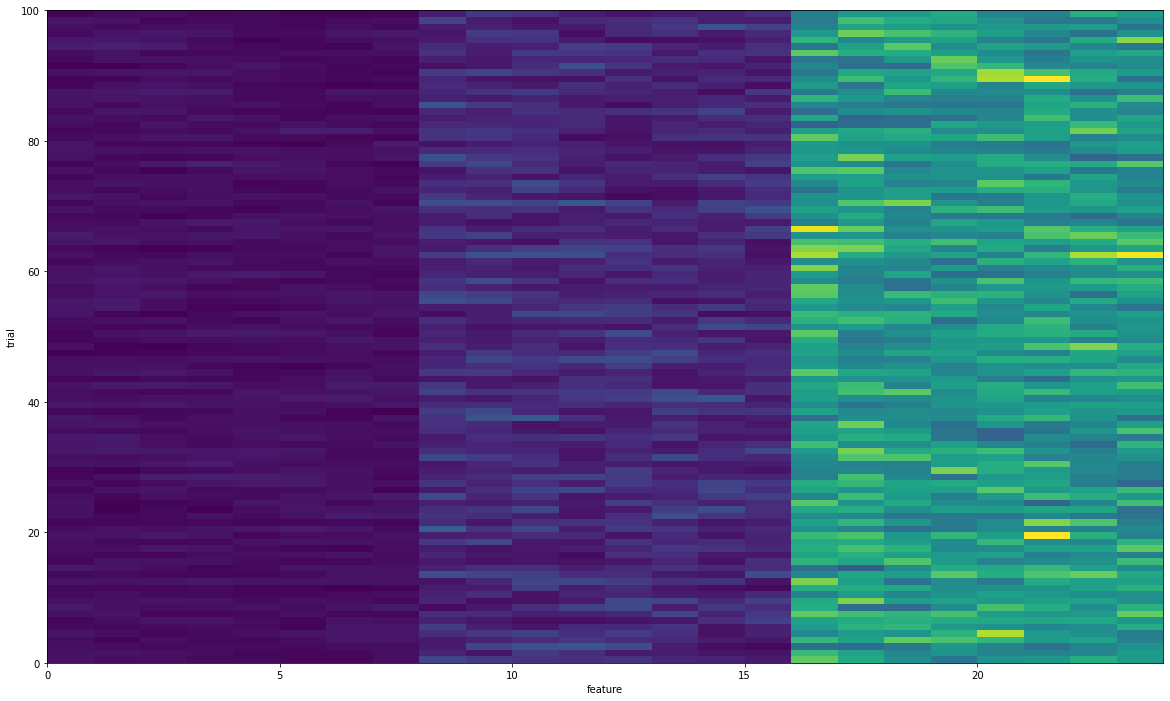

In [21]:

plt.figure(figsize=(20,12));
plt.pcolormesh(np.transpose(features_spat))
# plt.pcolormesh(np.transpose(features_freq))
# for ii in np.arange(0,432,36):
#     plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('trial')


Text(0, 0.5, 'trial')

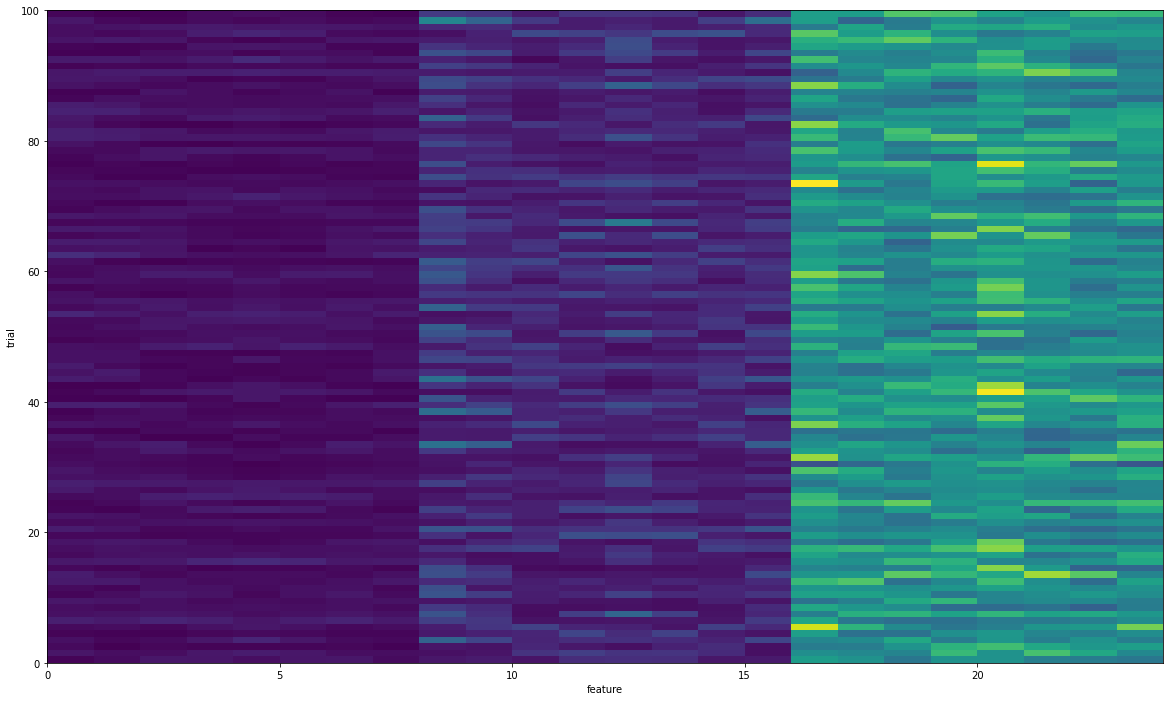

In [54]:

plt.figure(figsize=(20,12));
# plt.pcolormesh(np.transpose(features_spat))
plt.pcolormesh(np.transpose(features_freq))
# for ii in np.arange(0,432,36):
#     plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('trial')


Text(0, 0.5, 'trial')

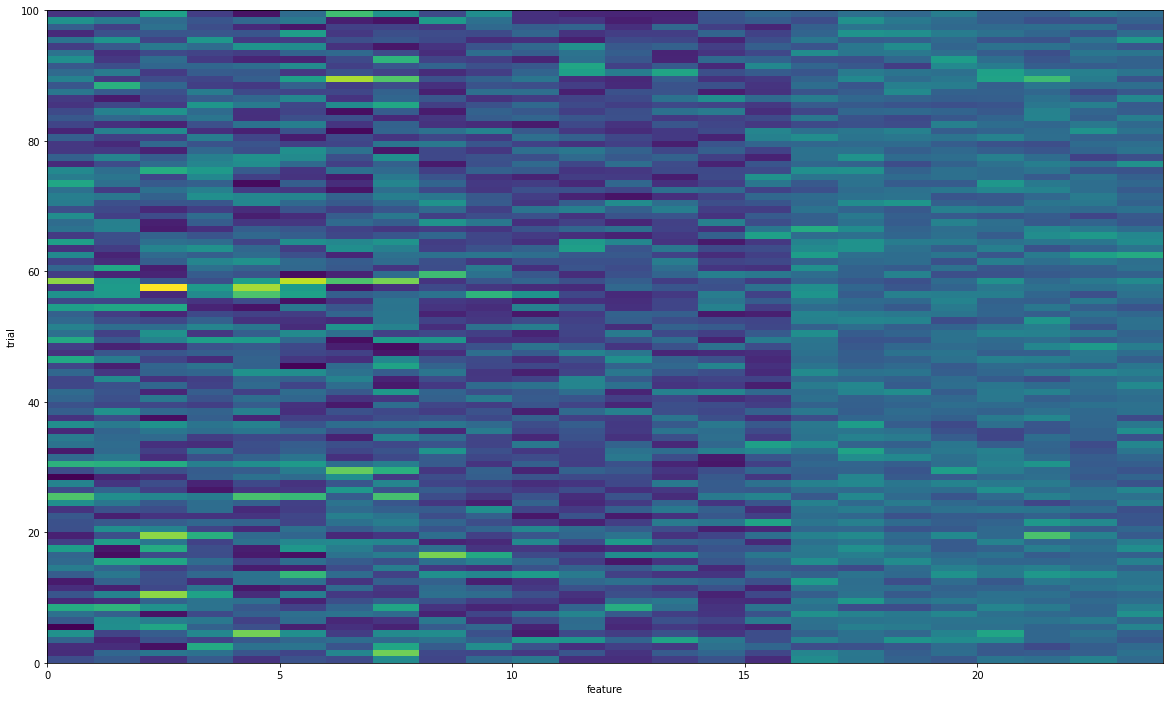

In [22]:
plt.figure(figsize=(20,12));
plt.pcolormesh(features_gab)
# for ii in np.arange(0,432,36):
#     plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('trial')


Text(0, 0.5, 'mean value across trials')

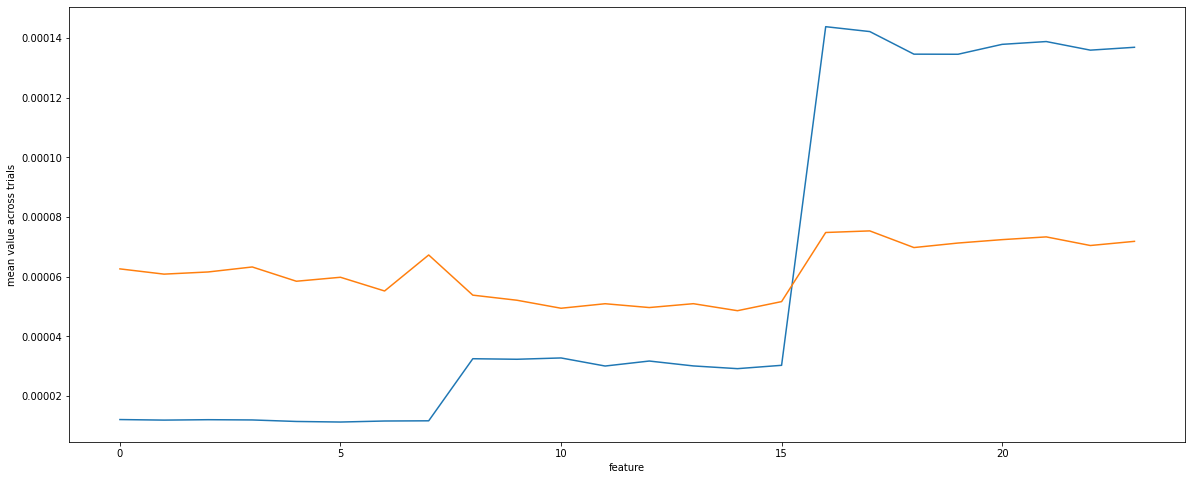

In [24]:
plt.figure(figsize=(20,8));
plt.plot(np.mean(np.transpose(features_spat),axis=0))
# plt.plot(np.mean(np.transpose(features_freq),axis=0))
plt.plot(np.mean(features_gab,axis=0))
# for ii in np.arange(0,432,36):
#     plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
# plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('mean value across trials')

Text(0, 0.5, 'variance across trials')

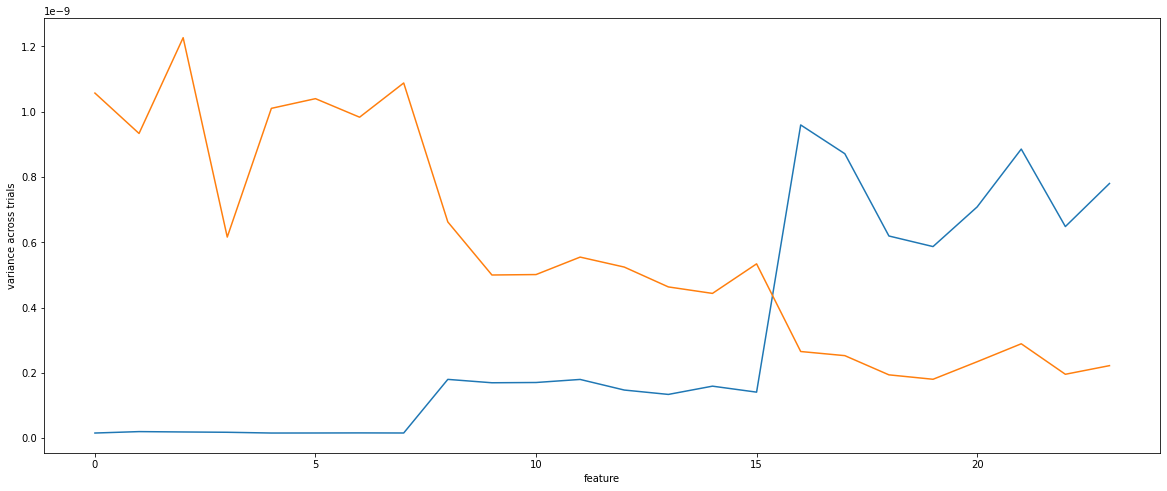

In [25]:
plt.figure(figsize=(20,8));
plt.plot(np.var(np.transpose(features_spat),axis=0))
# plt.plot(np.var(np.transpose(features_freq),axis=0))
plt.plot(np.var(features_gab,axis=0))
# for ii in np.arange(0,432,36):
#     plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
# plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('variance across trials')

([], [])

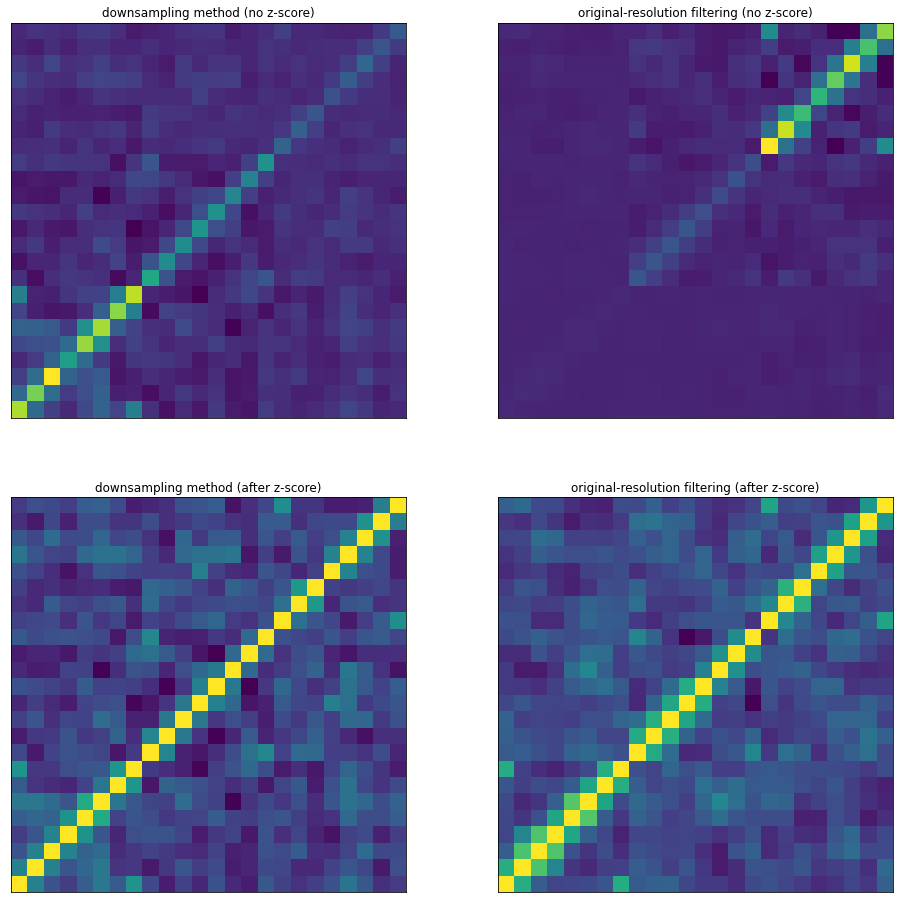

In [31]:
# Plot the covariance matrices together for comparison. 

import scipy

plt.figure(figsize=(16,16));
plt.subplot(2,2,1)
feat = features_gab
cov_gab = np.cov(np.transpose(feat))
plt.pcolormesh(cov_gab)
plt.axis('square')
plt.title('downsampling method (no z-score)')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,2)
feat = features_spat
cov_spat = np.cov(feat)
plt.pcolormesh(cov_spat)
plt.axis('square')
plt.title('original-resolution filtering (no z-score)')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
feat = scipy.stats.zscore(features_gab,axis=0)
cov_gab = np.cov(np.transpose(feat))
plt.pcolormesh(cov_gab)
plt.axis('square')
plt.title('downsampling method (after z-score)')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,4)
feat = scipy.stats.zscore(features_spat,axis=1)
cov_spat = np.cov(feat)
plt.pcolormesh(cov_spat)
plt.axis('square')
plt.title('original-resolution filtering (after z-score)')
plt.xticks([])
plt.yticks([])


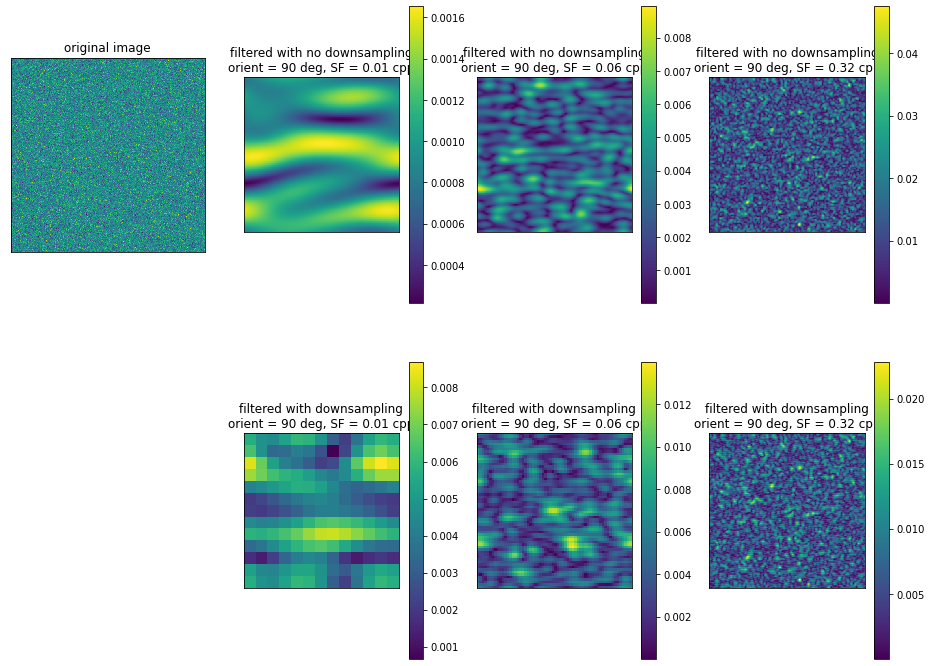

In [113]:
# Plotting all methods side by side

image_ind = 8

orient_labs = bank.orient_labs
a,orient_ind_list = np.unique(orient_labs,return_inverse=True)
freq_labs = bank.freq_labs
a,freq_ind_list = np.unique(freq_labs,return_inverse=True)

# a, orient_ind_list_old = np.unique(bank_old.orient_labs,return_inverse=True)
# a, freq_ind_list_old = np.unique(bank_old.freq_labs,return_inverse=True)

nFilts = len(orient_labs)

# ori2plot = (np.array([90,90,90]/5)).astype('int')
# sf2plot = np.array([2,6,10]).astype('int')

ori2plot = (np.array([90,90,90])/(180/8)).astype('int')
sf2plot = np.array([0,1,2]).astype('int')


plt.figure(figsize=(16,12));

plt.subplot(2,4,1)
plt.pcolormesh(random_images[image_ind,0,:,:])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

for ii in  range(len(sf2plot)):
    
    ff = np.where(np.logical_and(orient_ind_list==ori2plot[ii], freq_ind_list==sf2plot[ii]))[0][0];

    plt.subplot(2,4,2+ii)
    plt.pcolormesh(maps_spat[image_ind,:,:,ff])
#     plt.pcolormesh(maps_freq[image_ind,:,:,ff])
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered with no downsampling\norient = %d deg, SF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    
    plt.subplot(2,4,6+ii)
    plt.pcolormesh(maps_gab[sf2plot[ii]][image_ind,ori2plot[ii],:,:])
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered with downsampling\norient = %d deg, SF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    

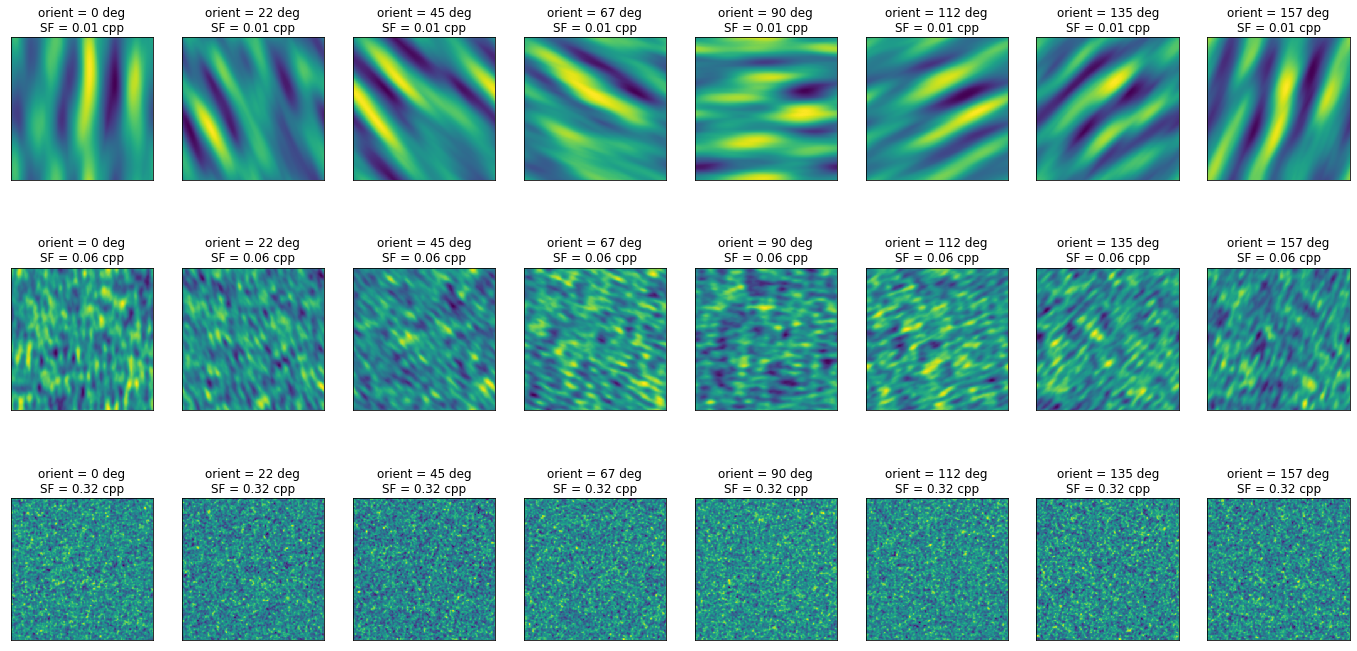

In [89]:
# plot average over maps for many images (want to see spatial distribution of energy)

plt.figure(figsize=(24,12))
for ff in range(np.shape(maps_spat)[3]):
    
    plt.subplot(3,8,ff+1)
    plt.pcolormesh(np.mean(maps_spat[:,:,:,ff], axis=0))
    plt.axis('square')
    plt.xticks([]); plt.yticks([])
    plt.title('orient = %d deg\nSF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))

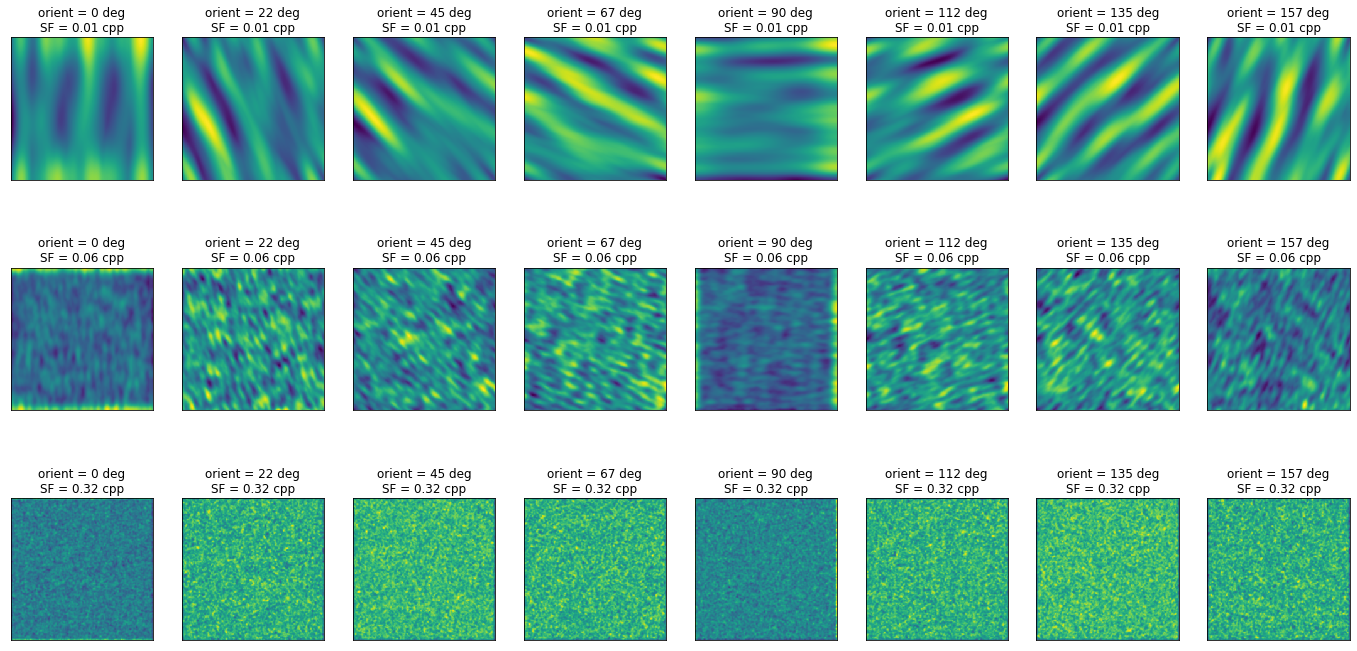

In [60]:
# plot average over maps for many images (want to see spatial distribution of energy)

plt.figure(figsize=(24,12))
for ff in range(np.shape(maps_freq)[3]):
    
    plt.subplot(3,8,ff+1)
    plt.pcolormesh(np.mean(maps_freq[:,:,:,ff], axis=0))
    plt.axis('square')
    plt.xticks([]); plt.yticks([])
    plt.title('orient = %d deg\nSF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))

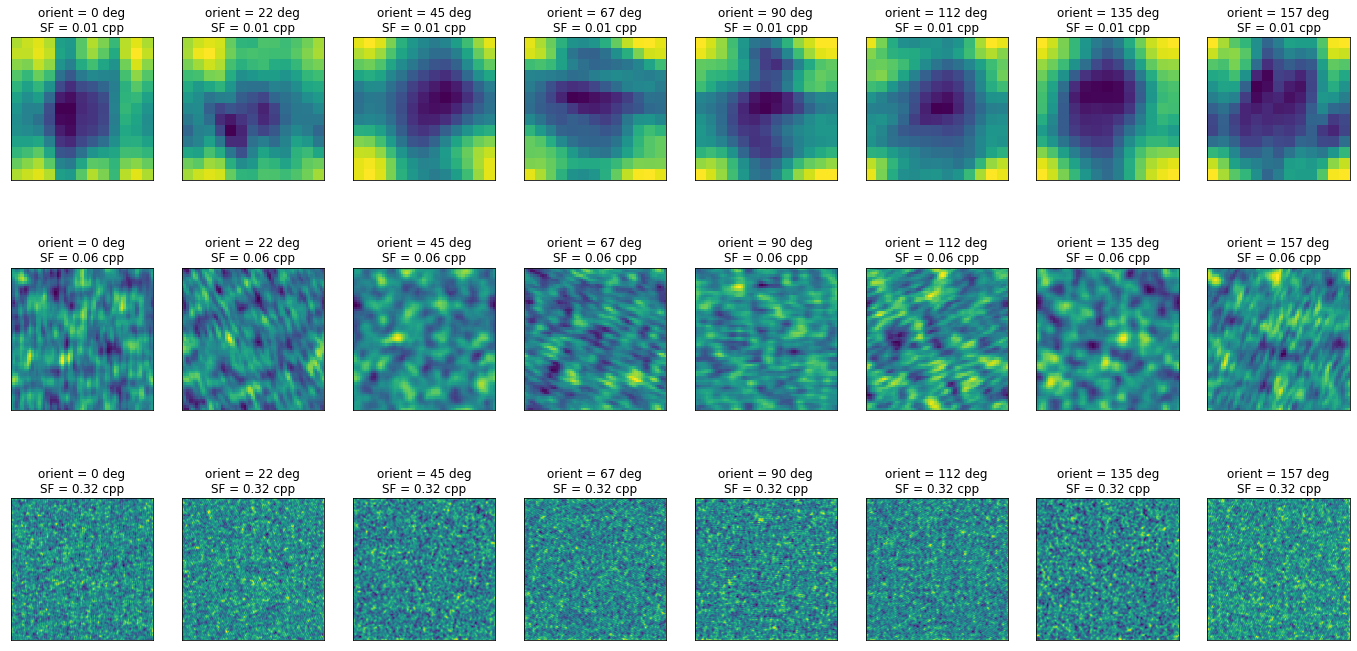

In [114]:
# plot average over maps for many images (want to see spatial distribution of energy)


plt.figure(figsize=(24,12))
for ff in range(np.shape(maps_spat)[3]):
    
    plt.subplot(3,8,ff+1)
    plt.pcolormesh(np.mean(maps_gab[freq_ind_list[ff]][:,orient_ind_list[ff],:,:], axis=0))
    plt.axis('square')
    plt.xticks([]); plt.yticks([])
    plt.title('orient = %d deg\nSF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))

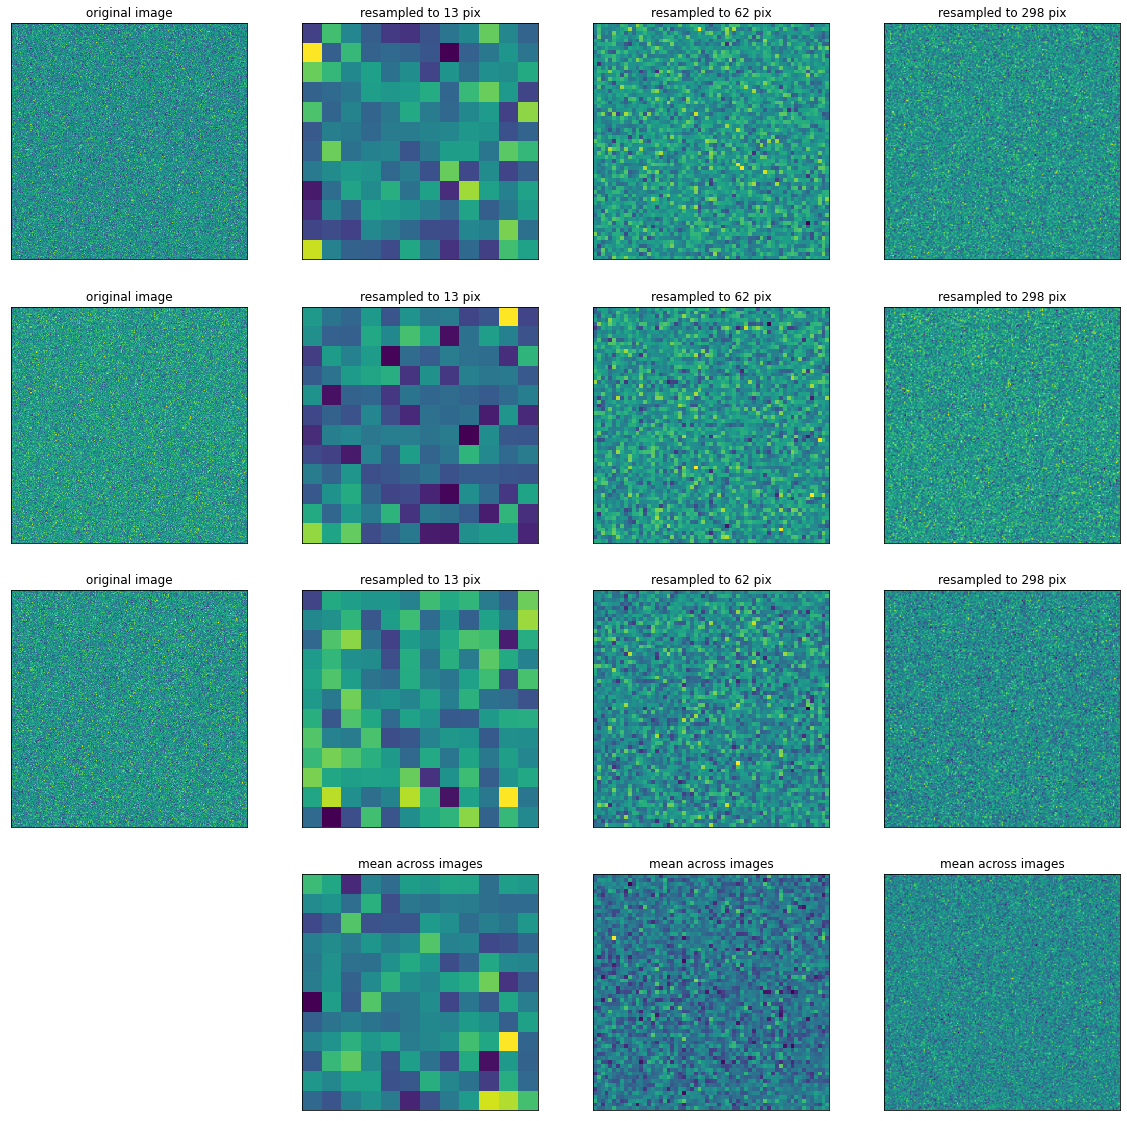

In [141]:
# visualize how the down-sampling works

plt.figure(figsize=(20,20));
ims2plot = np.arange(0,3)

n_images = 100
for ii, im in enumerate(ims2plot):
    plt.subplot(len(ims2plot)+1, len(fmaps_rez)+1, ii*(len(fmaps_rez)+1)+1)
    plt.pcolormesh(random_images[im,0,:,:])
    plt.axis('square')
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.title('original image')
   
    for rr, res in enumerate(fmaps_rez):
        
        downsample_fn = _fmaps_fn.gfe_list[rr].resam
        downsampled_ims = downsample_fn(_to_torch(random_images[0:n_images], device=device)).cpu().detach().numpy()

        plt.subplot(len(ims2plot)+1, len(fmaps_rez)+1, ii*(len(fmaps_rez)+1)+rr+2)
        plt.pcolormesh(downsampled_ims[im,0,:,:])
        plt.axis('square')
        plt.xticks([])
        plt.yticks([])
        plt.gca().invert_yaxis()
        plt.title('resampled to %d pix'%res)
        
for rr, res in enumerate(fmaps_rez):

    downsample_fn = _fmaps_fn.gfe_list[rr].resam
    downsampled_ims = downsample_fn(_to_torch(random_images[0:n_images], device=device)).cpu().detach().numpy()

    plt.subplot(len(ims2plot)+1, len(fmaps_rez)+1, (len(ims2plot))*(len(fmaps_rez)+1)+rr+2)
    plt.pcolormesh(np.mean(downsampled_ims[:,0,:,:],axis=0))
    plt.axis('square')
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.title('mean across images')

        

Text(0.5, 0.98, 'pad mode = reflect')

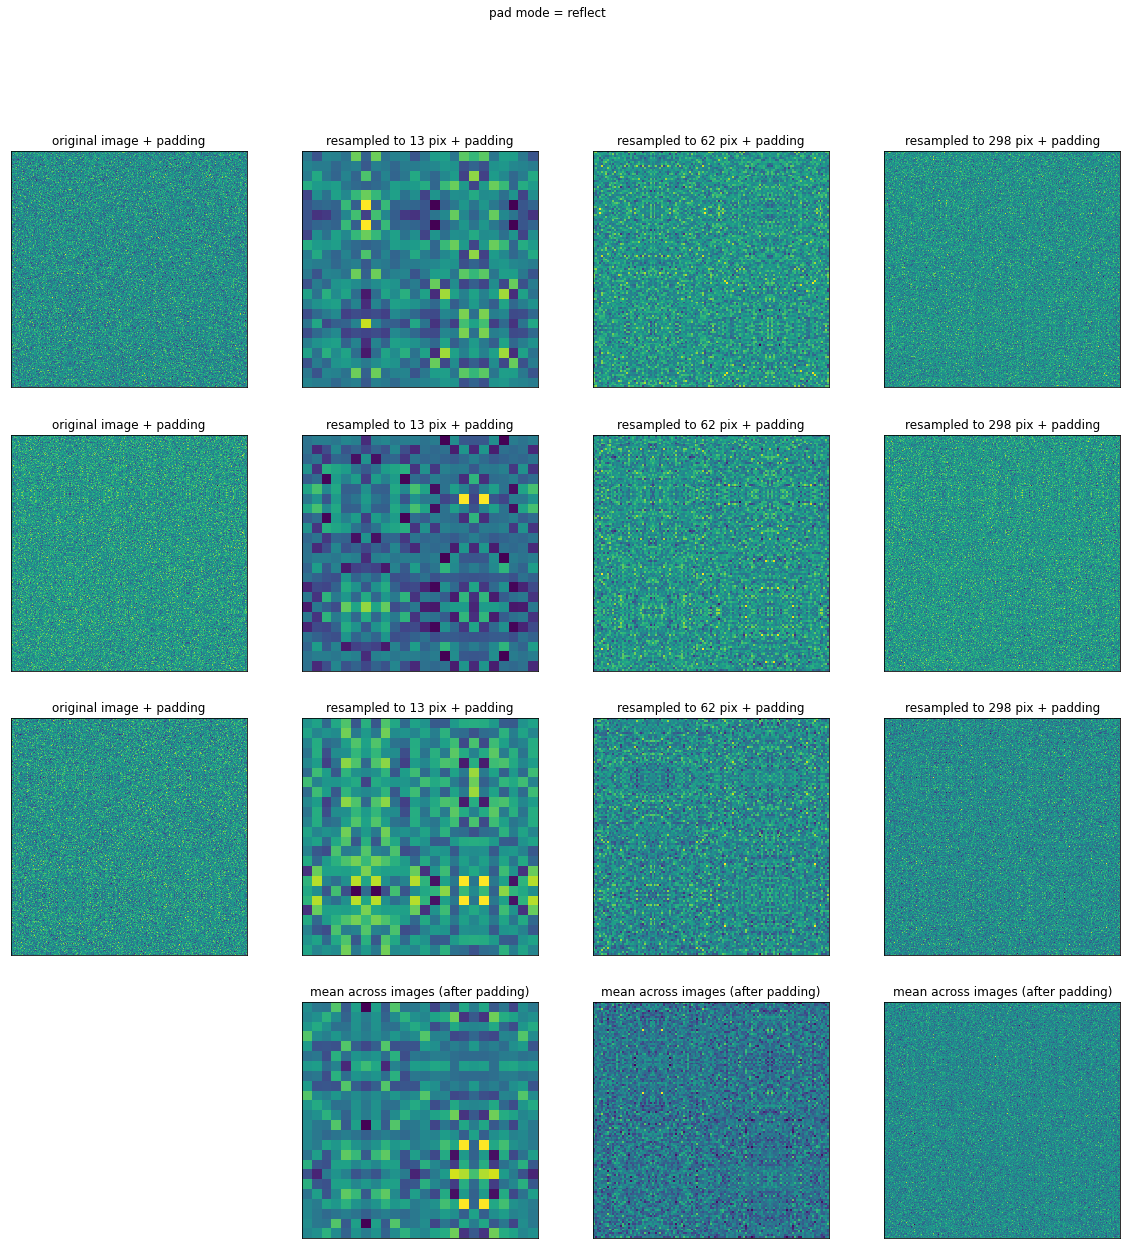

In [179]:
# Visualize how the padding works

plt.figure(figsize=(20,20));
ims2plot = np.arange(0,3)

# pad_mode='replicate'
# pad_mode='circular'
# pad_mode='constant'
pad_mode='reflect'

for ii, im in enumerate(ims2plot):
    plt.subplot(len(ims2plot)+1, len(fmaps_rez)+1, ii*(len(fmaps_rez)+1)+1)
    im2plot = random_images[im:im+1,0:1,:,:]
    pad_by = int(np.shape(im2plot)[2]/2)
    im_padded = torch.nn.functional.pad(_to_torch(im2plot),pad=(pad_by, pad_by,pad_by, pad_by), mode=pad_mode).cpu().detach().numpy()
    plt.pcolormesh(im_padded[0,0,:,:])
    plt.axis('square')
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.title('original image + padding')
   
    for rr, res in enumerate(fmaps_rez):
        
        downsample_fn = _fmaps_fn.gfe_list[rr].resam
        downsampled_ims = downsample_fn(_to_torch(random_images[0:n_images], device=device)).cpu().detach().numpy()

        plt.subplot(len(ims2plot)+1, len(fmaps_rez)+1, ii*(len(fmaps_rez)+1)+rr+2)
        
        im2plot = downsampled_ims[im:im+1,0:1,:,:]
        pad_by = int(np.shape(im2plot)[2]/2)
        im_padded = torch.nn.functional.pad(_to_torch(im2plot),pad=(pad_by, pad_by,pad_by, pad_by), mode=pad_mode).cpu().detach().numpy()

        
        plt.pcolormesh(im_padded[0,0,:,:])
        plt.axis('square')
        plt.xticks([])
        plt.yticks([])
        plt.gca().invert_yaxis()
        plt.title('resampled to %d pix + padding'%res)
        
for rr, res in enumerate(fmaps_rez):

    downsample_fn = _fmaps_fn.gfe_list[rr].resam
    downsampled_ims = downsample_fn(_to_torch(random_images[0:n_images], device=device)).cpu().detach().numpy()

    im2plot = downsampled_ims[:,0:1,:,:]
    pad_by = int(np.shape(im2plot)[2]/2)
    im_padded = torch.nn.functional.pad(_to_torch(im2plot),pad=(pad_by, pad_by,pad_by, pad_by), mode=pad_mode).cpu().detach().numpy()

    
    plt.subplot(len(ims2plot)+1, len(fmaps_rez)+1, (len(ims2plot))*(len(fmaps_rez)+1)+rr+2)
    plt.pcolormesh(np.mean(im_padded[:,0,:,:],axis=0))
    plt.axis('square')
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.title('mean across images (after padding)')

plt.suptitle('pad mode = %s'%pad_mode)

Text(0.5, 0.98, 'pad mode = reflect')

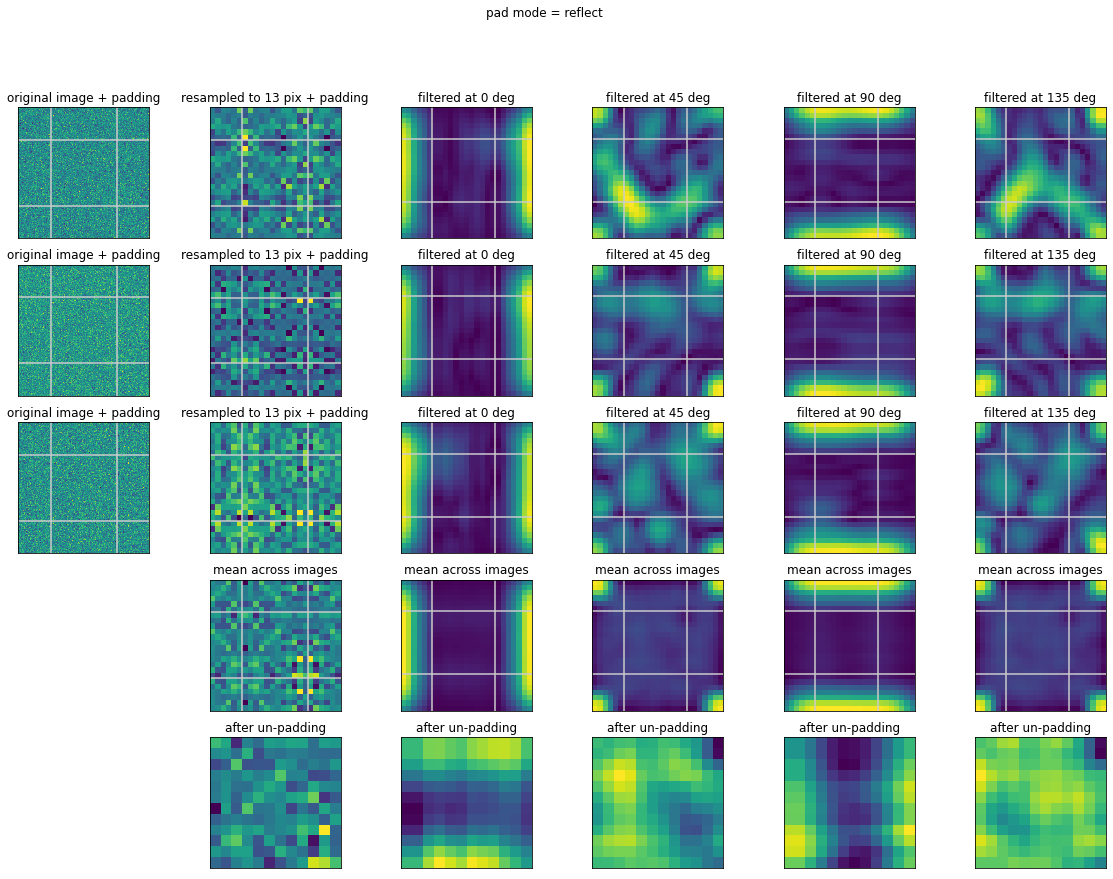

In [221]:
# Visualize how the filtering works after diff kinds of padding

plt.figure(figsize=(20,14));
ims2plot = np.arange(0,3)
ori2plot = np.arange(0,8,2)

npx = len(ims2plot)+2
npy = len(ori2plot)+2

# pad_mode='replicate'
# pad_mode='circular'
# pad_mode='constant'
pad_mode='reflect'

rr = 0
res = fmaps_rez[0]

downsample_fn = _fmaps_fn.gfe_list[rr].resam
downsampled_ims = downsample_fn(_to_torch(random_images[0:n_images], device=device)).cpu().detach().numpy()

pad_by_downsamp = int(np.shape(downsampled_ims)[2]/2)
ims_padded = torch.nn.functional.pad(_to_torch(downsampled_ims),pad=(pad_by_downsamp, pad_by_downsamp,pad_by_downsamp, pad_by_downsamp), mode=pad_mode).cpu().detach().numpy()

filters_real = _fmaps_fn.gfe_list[rr].real_filters_tnsr
filters_imag = _fmaps_fn.gfe_list[rr].imag_filters_tnsr
pad_by_conv = int(np.shape(filters)[2]/2)
ims_conv_real = torch.nn.functional.conv2d(_to_torch(ims_padded, device=device), filters_real, padding=(pad_by_conv, pad_by_conv)).cpu().detach().numpy()
ims_conv_imag = torch.nn.functional.conv2d(_to_torch(ims_padded, device=device), filters_imag, padding=(pad_by_conv, pad_by_conv)).cpu().detach().numpy()
ims_conv = np.sqrt(ims_conv_real**2 + ims_conv_imag**2)

for ii, im in enumerate(ims2plot):
    plt.subplot(npx,npy,ii*(npy)+1)

    im2plot = random_images[im:im+1,0:1,:,:]
    pad_by = int(np.shape(im2plot)[2]/2)
    im_padded = torch.nn.functional.pad(_to_torch(im2plot),pad=(pad_by, pad_by,pad_by, pad_by), mode=pad_mode).cpu().detach().numpy()
    plt.pcolormesh(im_padded[0,0,:,:])
    plt.axhline(pad_by,color=[0.8, 0.8, 0.8])
    plt.axhline(np.shape(im_padded)[2] - pad_by,color=[0.8, 0.8, 0.8])
    plt.axvline(pad_by,color=[0.8, 0.8, 0.8])
    plt.axvline(np.shape(im_padded)[2] - pad_by,color=[0.8, 0.8, 0.8])
    plt.axis('square')
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.title('original image + padding')

    plt.subplot(npx,npy,ii*(npy)+2)
    plt.pcolormesh(ims_padded[im,0,:,:])
    plt.axhline(pad_by_downsamp,color=[0.8, 0.8, 0.8])
    plt.axhline(np.shape(ims_padded)[2] - pad_by_downsamp,color=[0.8, 0.8, 0.8])
    plt.axvline(pad_by_downsamp,color=[0.8, 0.8, 0.8])
    plt.axvline(np.shape(ims_padded)[2] - pad_by_downsamp,color=[0.8, 0.8, 0.8])
    plt.axis('square')
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.title('resampled to %d pix + padding'%res)

    for oo, ori in enumerate(ori2plot):
        
        plt.subplot(npx,npy,ii*(npy)+2+1+oo)
        plt.pcolormesh(ims_conv[im,ori,:,:])
        plt.axhline(pad_by_downsamp,color=[0.8, 0.8, 0.8])
        plt.axhline(np.shape(ims_padded)[2] - pad_by_downsamp,color=[0.8, 0.8, 0.8])
        plt.axvline(pad_by_downsamp,color=[0.8, 0.8, 0.8])
        plt.axvline(np.shape(ims_padded)[2] - pad_by_downsamp,color=[0.8, 0.8, 0.8])
        plt.axis('square')
        plt.xticks([])
        plt.yticks([])
        plt.gca().invert_yaxis()
        plt.title('filtered at %d deg'%orients_deg[ori])

    
plt.subplot(npx,npy,(len(ims2plot))*(npy)+2)
plt.pcolormesh(np.mean(ims_padded[:,0,:,:], axis=0))
plt.axhline(pad_by_downsamp,color=[0.8, 0.8, 0.8])
plt.axhline(np.shape(ims_padded)[2] - pad_by_downsamp,color=[0.8, 0.8, 0.8])
plt.axvline(pad_by_downsamp,color=[0.8, 0.8, 0.8])
plt.axvline(np.shape(ims_padded)[2] - pad_by_downsamp,color=[0.8, 0.8, 0.8])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('mean across images')

for oo, ori in enumerate(ori2plot):

    plt.subplot(npx,npy,len(ims2plot)*(npy)+2+1+oo)
    plt.pcolormesh(np.mean(ims_conv[:,ori,:,:], axis=0))
    plt.axhline(pad_by_downsamp,color=[0.8, 0.8, 0.8])
    plt.axhline(np.shape(ims_padded)[2] - pad_by_downsamp,color=[0.8, 0.8, 0.8])
    plt.axvline(pad_by_downsamp,color=[0.8, 0.8, 0.8])
    plt.axvline(np.shape(ims_padded)[2] - pad_by_downsamp,color=[0.8, 0.8, 0.8])
    plt.axis('square')
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.title('mean across images')
    
plt.subplot(npx,npy,(len(ims2plot)+1)*(npy)+2)
plt.pcolormesh(np.mean(ims_padded[:,0,pad_by_downsamp:np.shape(ims_padded)[2] - pad_by_downsamp,pad_by_downsamp:np.shape(ims_padded)[2] - pad_by_downsamp], axis=0))

plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('after un-padding')

for oo, ori in enumerate(ori2plot):

    plt.subplot(npx,npy,(len(ims2plot)+1)*(npy)+2+1+oo)
    plt.pcolormesh(np.mean(ims_conv[:,ori,pad_by_downsamp:np.shape(ims_padded)[2] - pad_by_downsamp,pad_by_downsamp:np.shape(ims_padded)[2] - pad_by_downsamp], axis=0))

    plt.axis('square')
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.title('after un-padding')

plt.suptitle('pad mode = %s'%pad_mode)